In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

today = dt.datetime.now()
startdate = str(pd.Timestamp('2020-03-01').date())
enddate = str(today.date())
filepath = "/home/george/Documents/Field Security/Covid-19/datamining/chartpages/"
fname_base = "_charts.pdf"

plt.rcParams['figure.figsize'] = [11, 7]
# plt.close('all')

datafilename = "./covid-19-data-owid/public/data/ecdc/full_data.csv"
df = pd.read_csv(datafilename)
df.loc[df['location'] == 'Colombia'].tail(22)

asialist = ['Philippines','Indonesia','Japan','Thailand','Malaysia','Singapore','Australia','New Zealand']
westlist = ['United States','United Kingdom','Canada','Germany','France','Spain','Italy','Russia']
latam_list = ["Mexico",
    "Honduras",
    "Guatemala",
    "Bolivia",
    "Ecuador",
    "Panama",
    "Colombia",
    "Venezuela",
    "Peru",
    "Chile",
    "Paraguay",
    "Uruguay",
    "Argentina",
    "Brazil"]
latam_list_select = ["Mexico",
    "Bolivia",
    "Colombia",
    "Venezuela",
    "Paraguay",
    "Brazil"]
latam_list_largepop = ["Mexico",
    "Colombia",
    "Brazil"]


asiapop_dict = {'Philippines':106700000,
    'Indonesia':267700000,
    'Japan':126500000,
    'Thailand':69430000,
    'Malaysia':31530000,
    'Singapore':5639000,
    'Australia':24990000,
    'New Zealand':4886000}

latampop_dict = {"Mexico":127580000,
    "Honduras":9750000,
    "Guatemala":17580000,
    "Bolivia":11350000,
    "Ecuador":17370000,
    "Panama":4250000,
    "Colombia":50340000,
    "Venezuela":28520000,
    "Peru":32510000,
    "Chile":18950000,
    "Paraguay":7050000,
    "Uruguay":3460000,
    "Argentina":44900000,
    "Brazil":211050000}

asia_df = df.loc[df['location'] == asialist[0]].copy()
asia_df.set_index('date', inplace=True)

# print(startdate, enddate)
# asia_df = asia_df.loc[startdate:enddate]
# print(asia_df.columns.tolist())
# asia_df['shiftertest'] = asia_df['new_cases'].shift(1)
# # asia_df[['location','new_cases','shiftertest']].tail(10)
# asia_df.tail()

In [2]:
def total_cases(alist, startdate, df, excludelist=[], kind='line', permil = False, pop_dict={}, titlextra='', fname=''):
    countrylist = alist.copy()
    newplot_df = pd.DataFrame()
    tc_cols_list = []
    today = dt.datetime.now()
    for x in excludelist:
        if x in countrylist:
            countrylist.remove(x)
            
    for c in countrylist:
        country_df = df.loc[df['location'] == c].copy()
        country_df.set_index('date', inplace=True)
        dateslist = country_df[country_df.new_deaths >= 5].index.tolist()
        if len(dateslist) > 0:
            if dateslist[0] < startdate:
                startdate = dateslist[0]
        country_df = country_df.loc[startdate:]    
        tc_header = 'TC_' + c
        tc_cols_list.append(tc_header)
        if permil:
            country_pop = pop_dict[c]
            country_df[tc_header] = round(country_df['total_cases'] / country_pop * 1000000, 1)
            country_df.drop(axis=1, labels=['total_cases'], inplace=True)
            chart_title = 'Total Cases per Million ' + titlextra
        else:
            country_df.rename(columns = {'total_cases' : tc_header}, inplace=True)
            chart_title = 'Total Cases ' + titlextra
        
        if newplot_df.empty:
            newplot_df = country_df[[tc_header]]
        else:
            newplot_df = newplot_df.merge(country_df[[tc_header]], how='inner', left_index=True, right_index=True)

    if kind=='line':
        ax = newplot_df.plot()
        ax.grid()
        plt.xlabel('date', fontsize=18)
        plt.ylabel('case count', fontsize=18)
        plt.title(chart_title, fontsize=24)
    elif kind=='bar':
        xpos = np.arange(len(countrylist))
        valslist = newplot_df.loc[enddate].tolist()
        plt.xticks(xpos, countrylist)
        plt.bar(xpos, valslist, align='center', width=0.6)
        plt.title(chart_title, fontsize=24)

    if fname != '':
        fname_final = filepath + fname + fname_base
        with PdfPages(fname_final) as export_pdf:
            export_pdf.savefig()
            plt.show()
            plt.close()
    else:
        plt.show()
        plt.close()
    
# total_cases(asialist, startdate, df, permil=False, fname='totalcasetest')

In [3]:
def ctd_ratio(alist, startdate, df, excludelist=[], kind='line', titlextra='', fname=''):
    countrylist = alist.copy()
    newplot_df = pd.DataFrame()
    ctd_cols_list = []
    today = dt.datetime.now()
    
    for x in excludelist:
        if x in countrylist:
            countrylist.remove(x)
    for c in countrylist:
        country_df = df.loc[df['location'] == c].copy()
        country_df.set_index('date', inplace=True)
        dateslist = country_df[country_df.new_deaths >= 5].index.tolist()
        if len(dateslist) > 0:
            if dateslist[0] < startdate:
                startdate = dateslist[0]
        country_df = country_df.loc[startdate:]    
        country_df['cases_shift'] = country_df['total_cases'].shift(21)
        # CASES TO DEATH RATIO
        ctd_header = 'CTD_' + c
        country_df[ctd_header] = round(country_df['cases_shift'] / country_df['total_deaths'],2)
        country_df.drop(axis=1, labels=['cases_shift'], inplace=True)
        ctd_cols_list.append(ctd_header)
        if newplot_df.empty:
            newplot_df = country_df[[ctd_header]]
        else:
            newplot_df = newplot_df.merge(country_df[[ctd_header]], how='inner', left_index=True, right_index=True)

    if kind=='line':
        ax = newplot_df.plot()
        ax.grid()
        plt.xlabel('date', fontsize=18)
        plt.ylabel('ratio', fontsize=18)
        plt.title('Cases to Deaths Ratio ' + titlextra, fontsize=24)
    elif kind=='bar':
        xpos = np.arange(len(countrylist))
        valslist = newplot_df.loc[enddate].tolist()
        plt.xticks(xpos, countrylist)
        plt.bar(xpos, valslist, align='center', width=0.6)
        plt.title('Cases to Deaths Ratio ' + titlextra, fontsize=24)
        
    if fname != '':
        fname_final = filepath + fname + fname_base
        with PdfPages(fname_final) as export_pdf:
            export_pdf.savefig()
            plt.show()
            plt.close()
    else:
        plt.show()
        plt.close()

    
# ctd_ratio(asialist, startdate, df, excludelist=['Singapore'])


In [4]:
# new cases 7 day rolling average
# modified to do the same calculations for new deaths

def new_cases(alist, startdate, df, excludelist=[], kind='line', ROC=False, casetype='cases', titlextra='', period=7, fname=''):
    countrylist = alist.copy()
    newplot_df = pd.DataFrame()
    nc_cols_list = []
    today = dt.datetime.now()
    enddate = str(today.date())
    if casetype == 'cases':
        titleitem = 'Cases'
        hdritem = 'new_cases'
    elif casetype == 'deaths':
        titleitem = 'Deaths'
        hdritem = 'new_deaths'
    
    for x in excludelist:
        if x in countrylist:
            countrylist.remove(x)
    for c in countrylist:
        country_df = df.loc[df['location'] == c].copy()
        country_df.set_index('date', inplace=True)
        country_df = country_df.loc[startdate:enddate]    
        nc_header = 'NC_' + c
        country_df[nc_header] = country_df[hdritem].rolling(period).mean()
        country_df[nc_header] = round(country_df[nc_header],1)
        if ROC:
            ncroc_hdr = nc_header + '_ROC'
            country_df[ncroc_hdr] = (country_df[nc_header] - country_df[nc_header].shift(1)) / country_df[nc_header].shift(1) * 100
            country_df[ncroc_hdr] = country_df[ncroc_hdr].rolling(7).mean()
            country_df[ncroc_hdr] = round(country_df[ncroc_hdr],1)
            country_df.drop(axis=1, labels=[nc_header], inplace=True)
            nc_cols_list.append(ncroc_hdr)
            roctitle = ' Rate of Change Pct'
            ylabelstr = 'Percent ROC'
            if newplot_df.empty:
                newplot_df = country_df[[ncroc_hdr]]
            else:
                newplot_df = newplot_df.merge(country_df[[ncroc_hdr]], how='inner', left_index=True, right_index=True)
        else:
            nc_cols_list.append(nc_header)
            roctitle = ''
            ylabelstr = 'ratio'
            if newplot_df.empty:
                newplot_df = country_df[[nc_header]]
            else:
                newplot_df = newplot_df.merge(country_df[[nc_header]], how='inner', left_index=True, right_index=True)

    fulltitlestr = 'New ' + titleitem + ' ' + str(period) + ' day rolling avg' + roctitle + ' ' + titlextra
    if kind=='line':
        ax = newplot_df.plot()
        ax.grid()
        plt.xlabel('date', fontsize=18)
        plt.ylabel(ylabelstr, fontsize=18)
        plt.title(fulltitlestr, fontsize=24)
    elif kind=='bar':
        xpos = np.arange(len(countrylist))
        valslist = newplot_df.loc[enddate].tolist()
        plt.grid(axis='y')
        plt.xticks(xpos, countrylist)
        plt.ylabel(ylabelstr, fontsize=18)
        plt.bar(xpos, valslist, align='center', width=0.5)
        plt.title(fulltitlestr + ' today snapshot', fontsize=24)
    
    if fname != '':
        fname_final = filepath + fname + fname_base
        with PdfPages(fname_final) as export_pdf:
            export_pdf.savefig()
            plt.show()
            plt.close()
    else:
        plt.show()
        plt.close()
    
# new_cases(asialist, startdate, df)


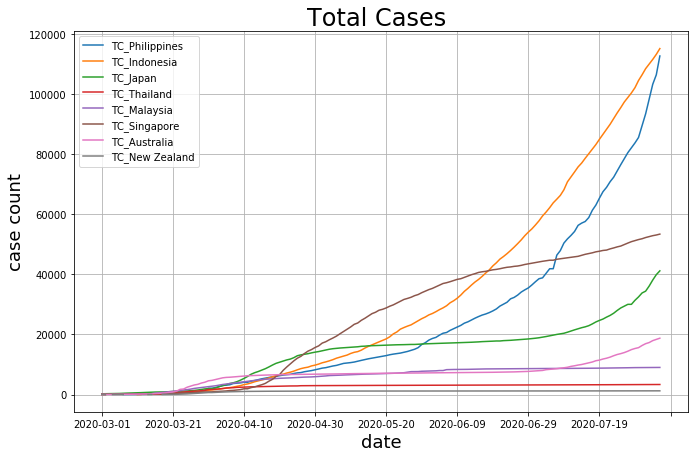

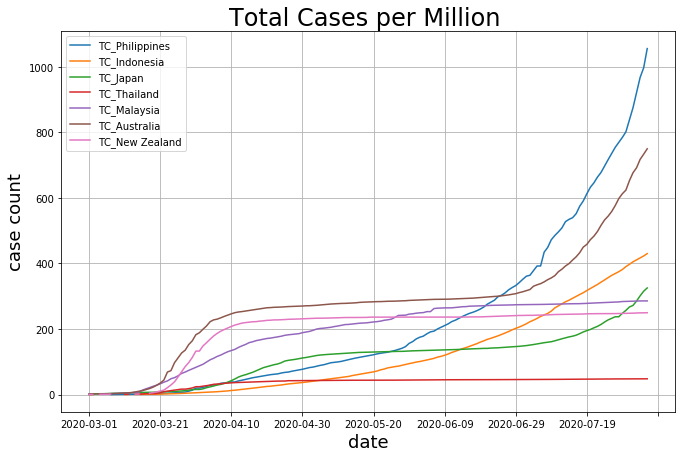

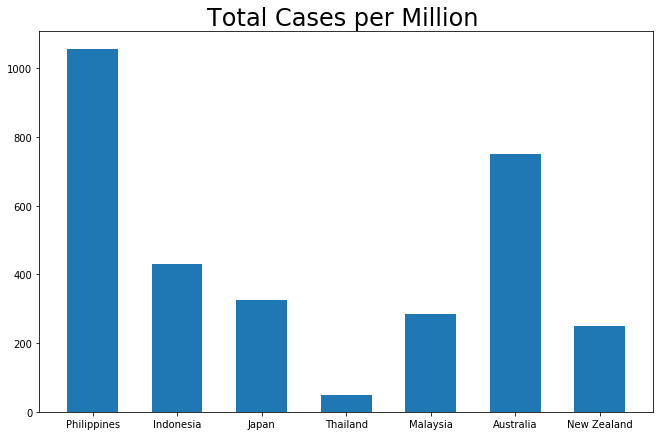

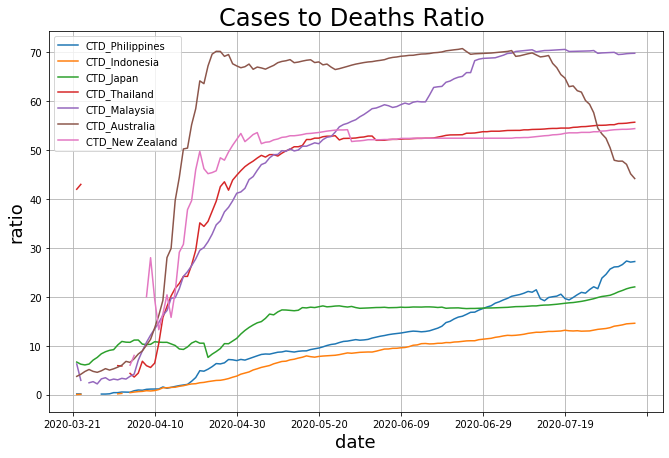

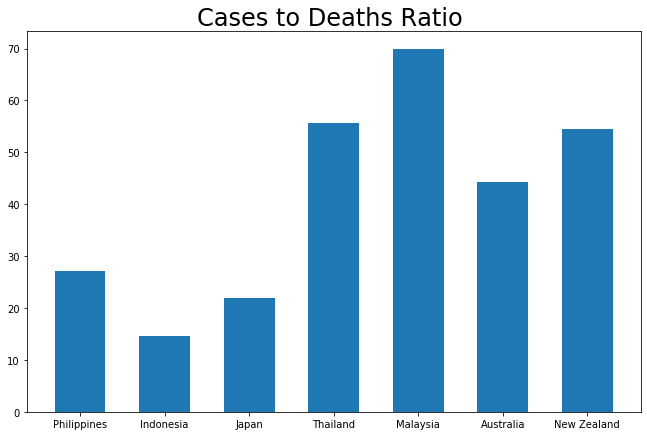

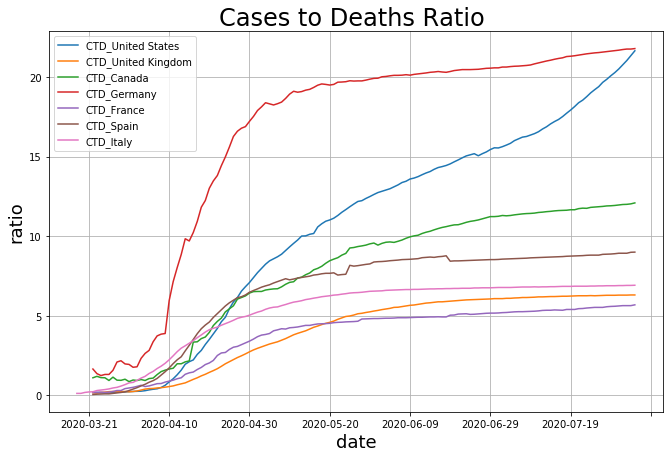

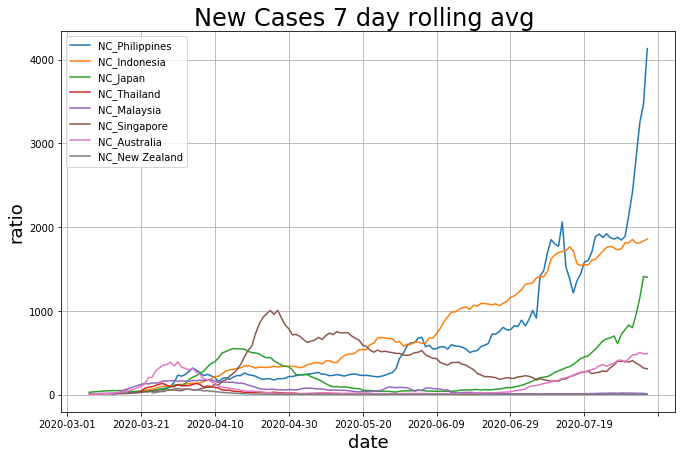

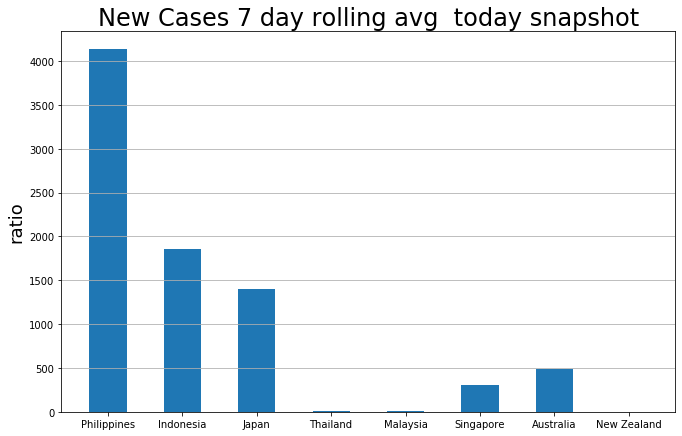

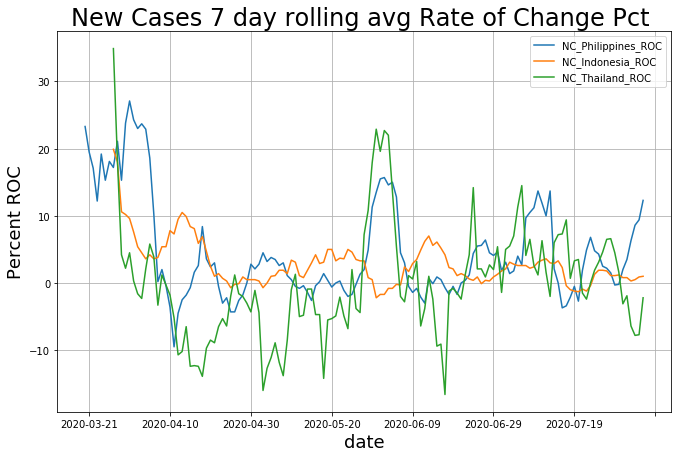

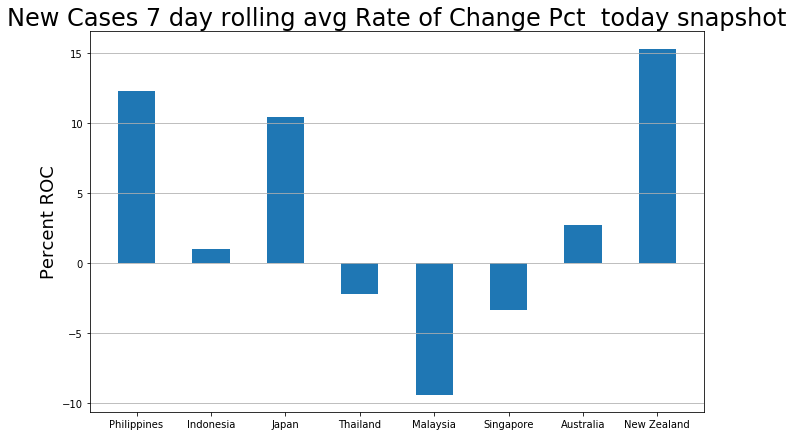

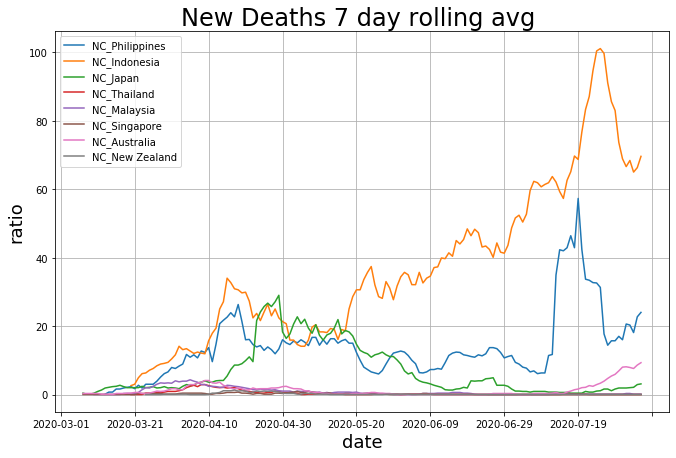

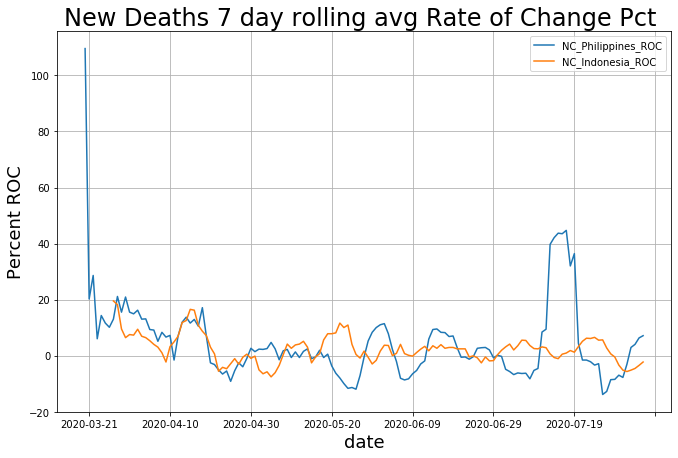

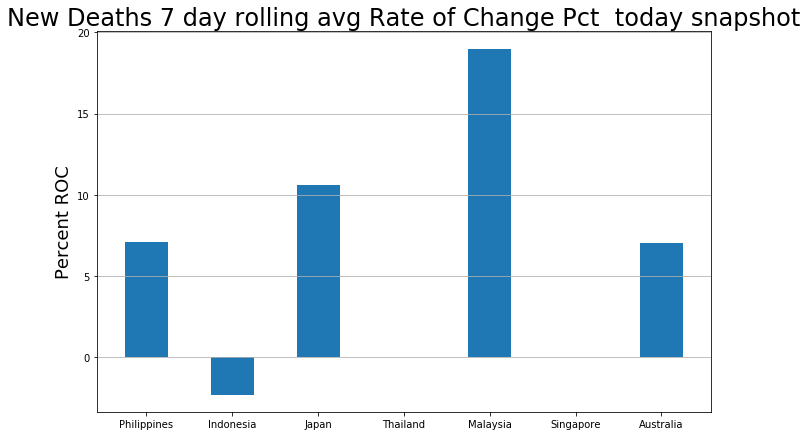

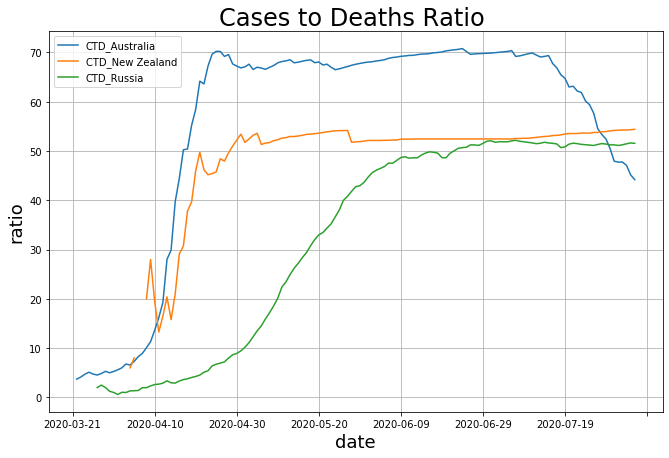

In [5]:
total_cases(asialist, startdate, df, permil=False, fname='01_AsiaTotal')
total_cases(asialist, startdate, df, permil=True, pop_dict=asiapop_dict, excludelist=['Singapore'], fname='02_AsiaPerMil')
total_cases(asialist, startdate, df, permil=True, pop_dict=asiapop_dict, excludelist=['Singapore'], kind='bar', fname='03_AsiaPerMilBar')

ctd_ratio(asialist, startdate, df, excludelist=['Singapore'], fname='04_AsiaCTD')
ctd_ratio(asialist, startdate, df, excludelist=['Singapore'], kind='bar', fname='05_AsiaCTD_bar')

ctd_ratio(westlist, startdate, df, excludelist=['Russia'], fname='06_AsiaWest')

new_cases(asialist, startdate, df, fname='07_AsiaNew')
new_cases(asialist, startdate, df, kind='bar', fname='08_AsiaNewBar')
new_cases(['Philippines','Indonesia','Thailand'], startdate, df, ROC=True, fname='09_AsiaROC_Top3')
new_cases(asialist, startdate, df, kind='bar', ROC=True, fname='10_Asia_ROC_bar')
new_cases(asialist, startdate, df, casetype='deaths', fname='11_AsiaDeaths')
new_cases(['Philippines','Indonesia'], startdate, df, casetype='deaths', ROC=True, fname='12_AsiaDeaths_ROC')
new_cases(asialist, startdate, df, casetype='deaths', ROC=True, kind='bar', fname='13_AsiaDeaths_bar')
ctd_ratio(['Australia','New Zealand','Russia'], startdate, df, fname='14_AsiaWestCTD')

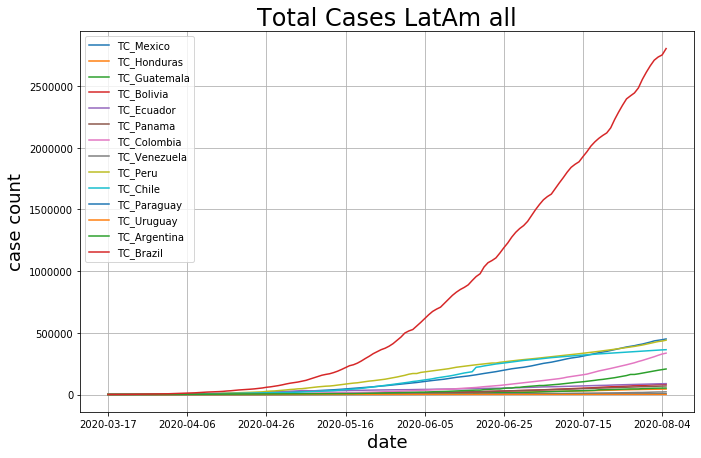

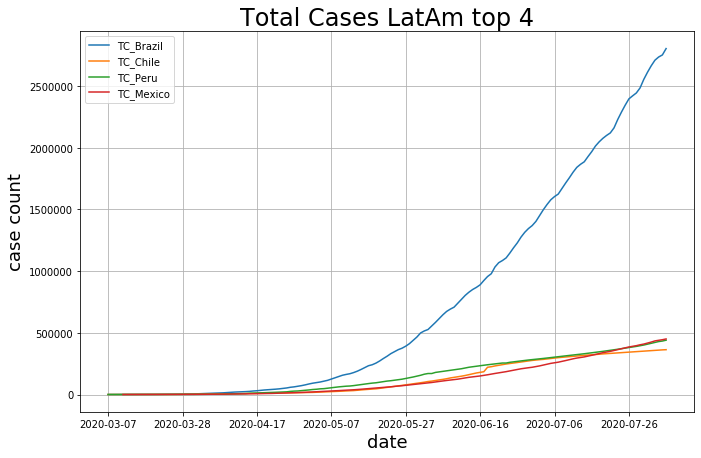

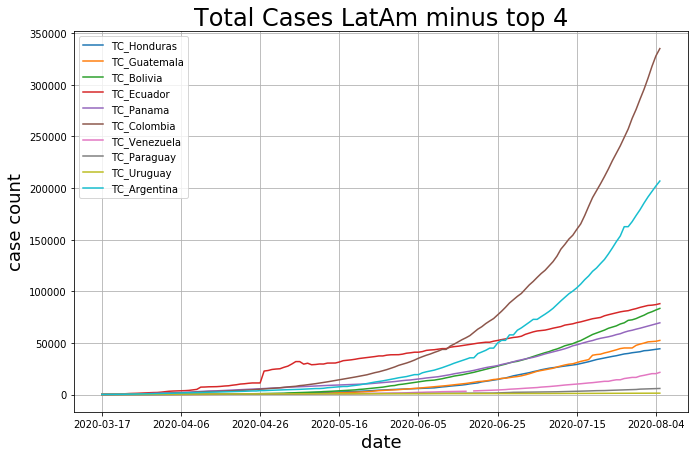

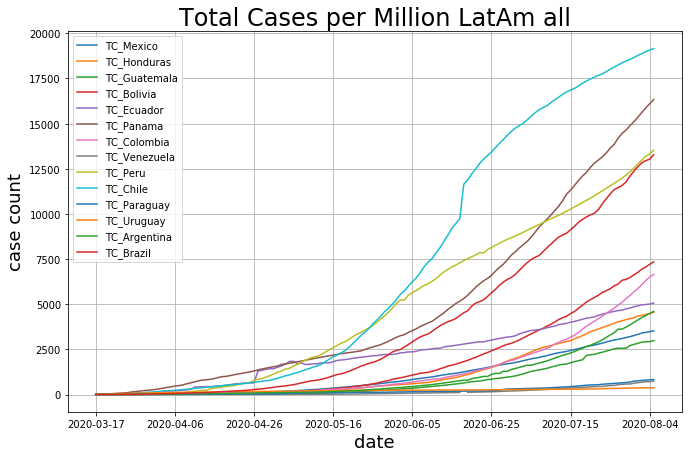

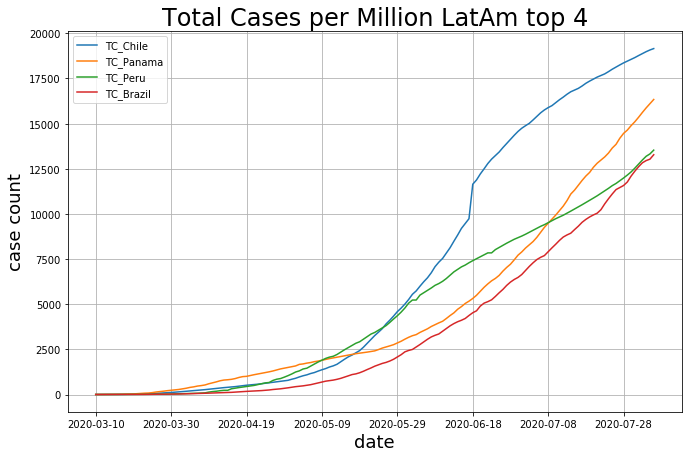

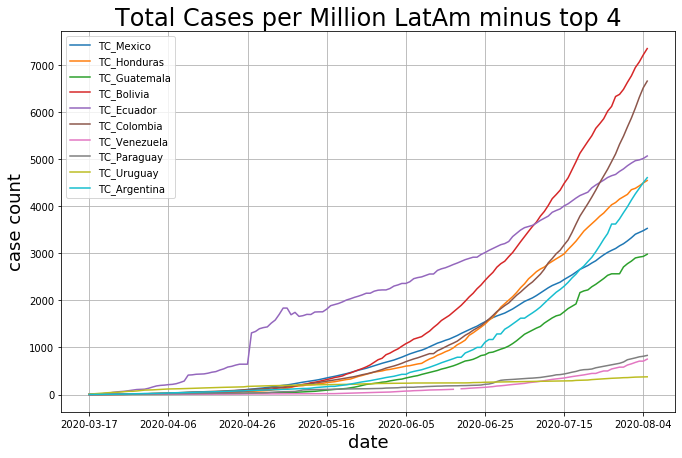

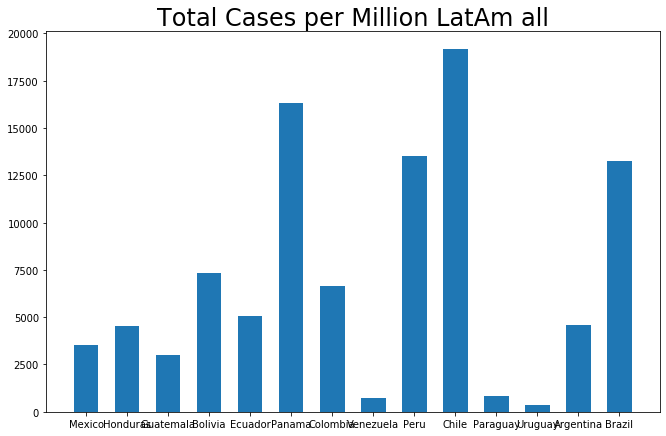

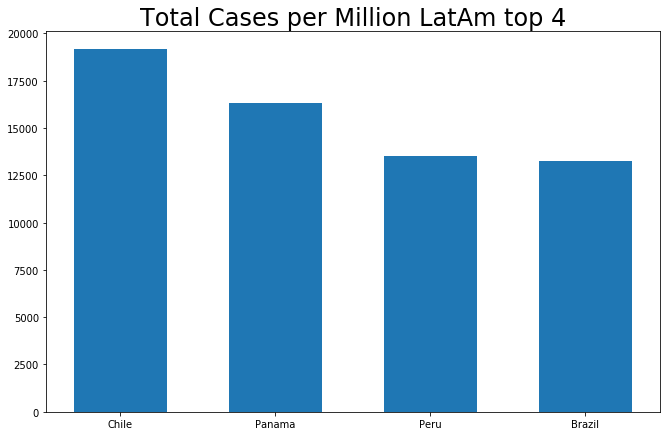

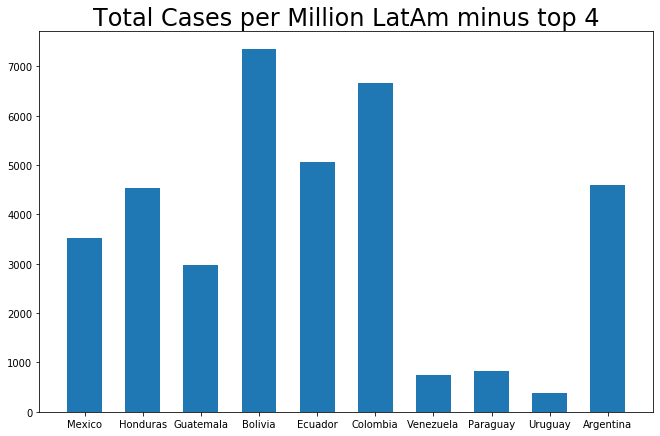

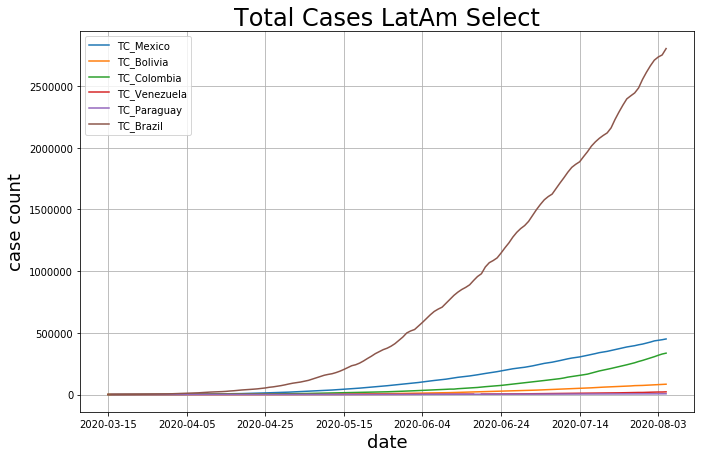

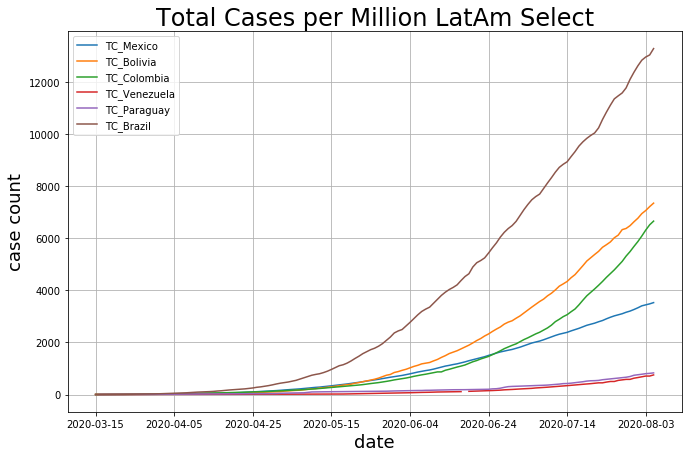

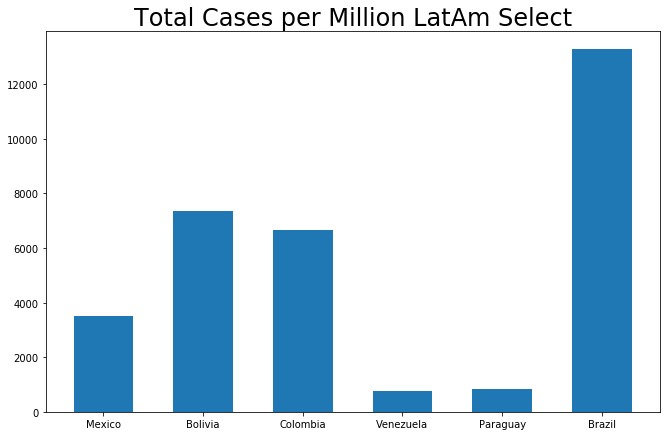

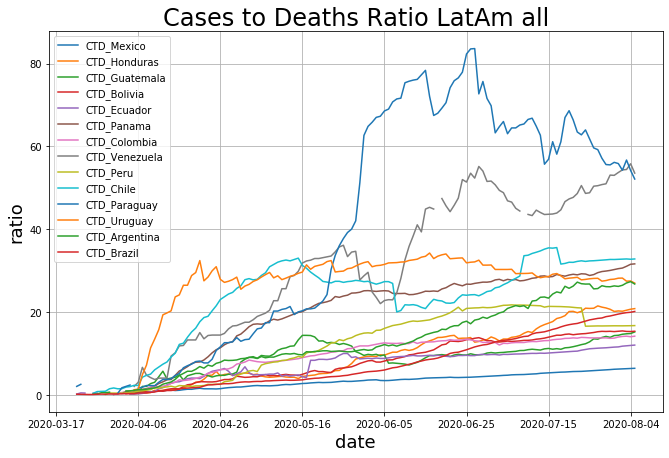

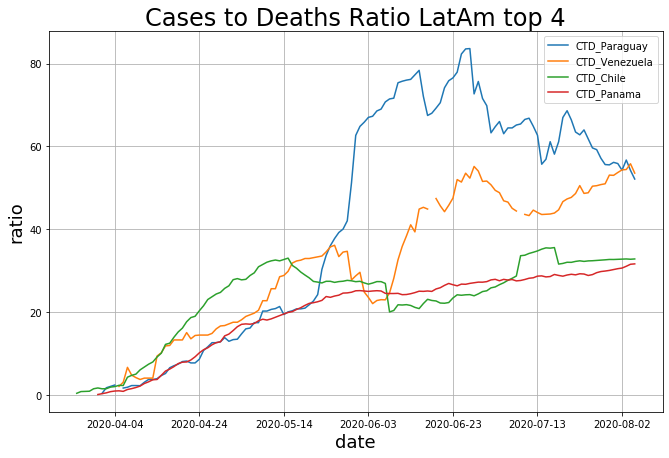

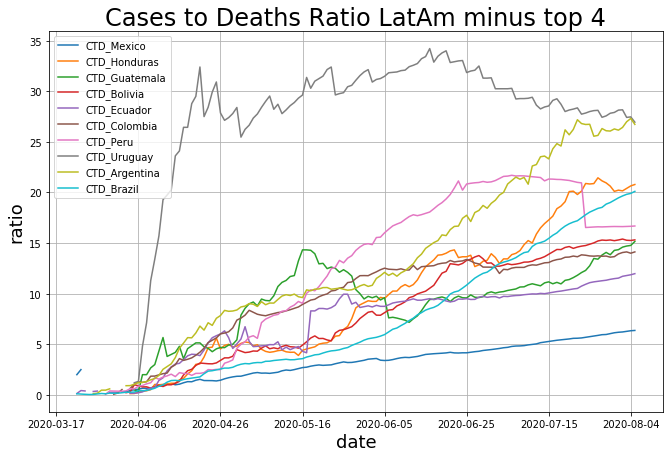

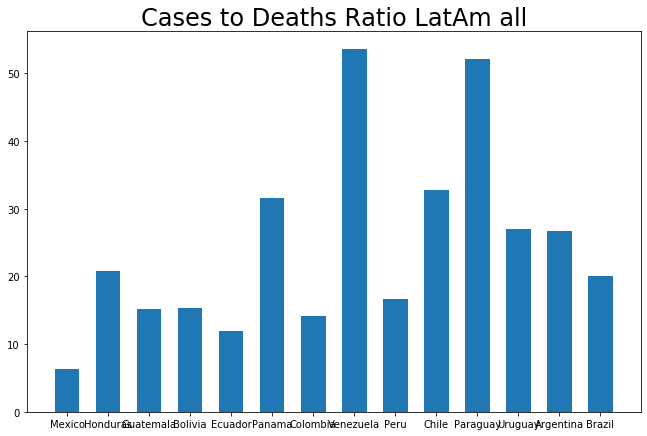

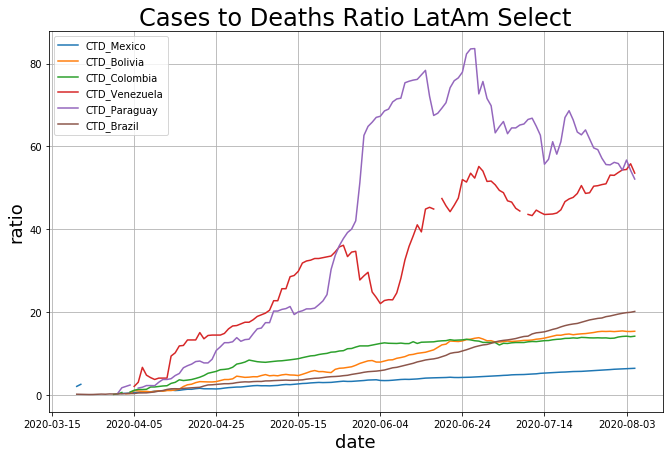

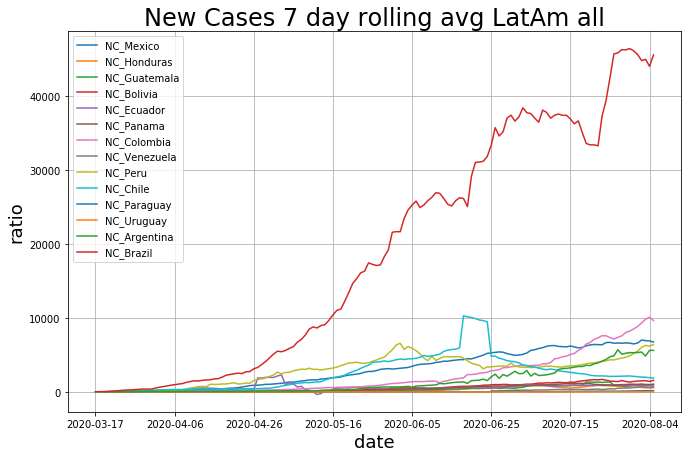

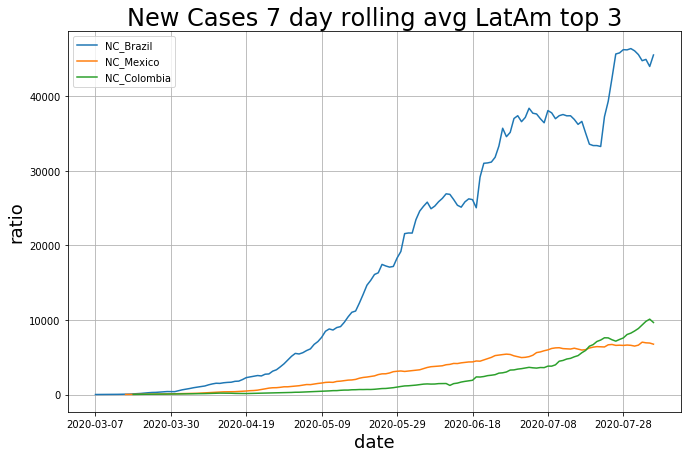

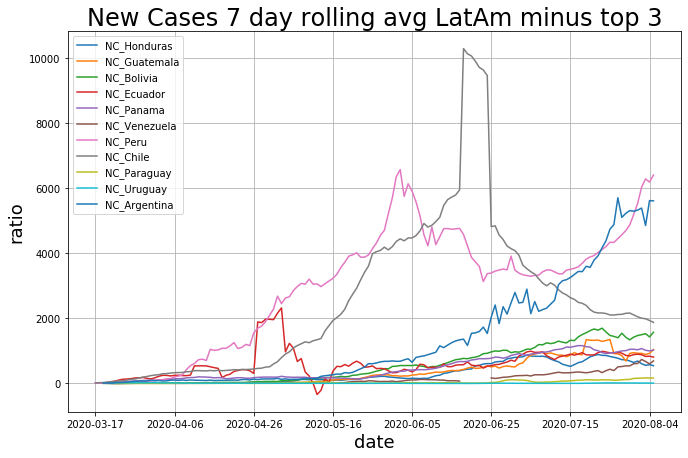

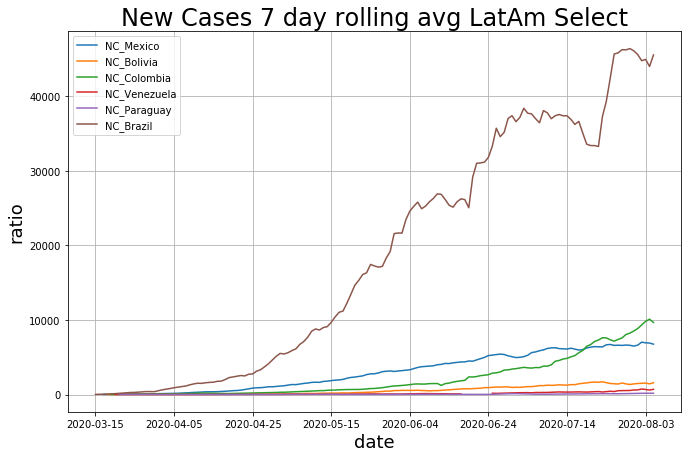

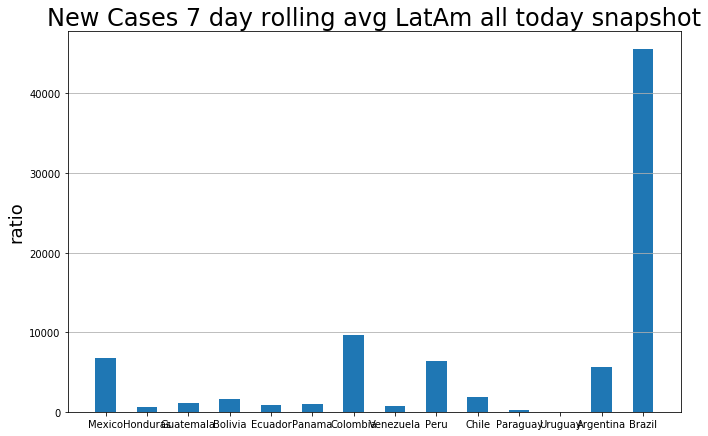

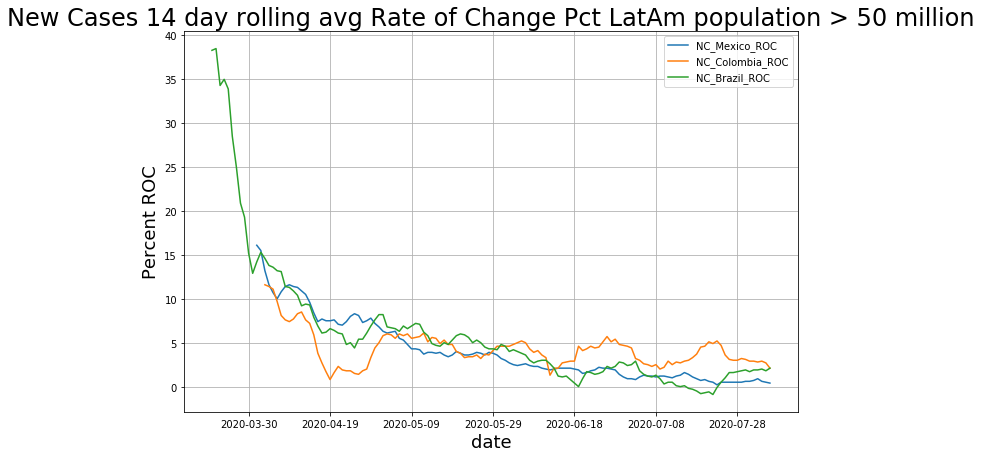

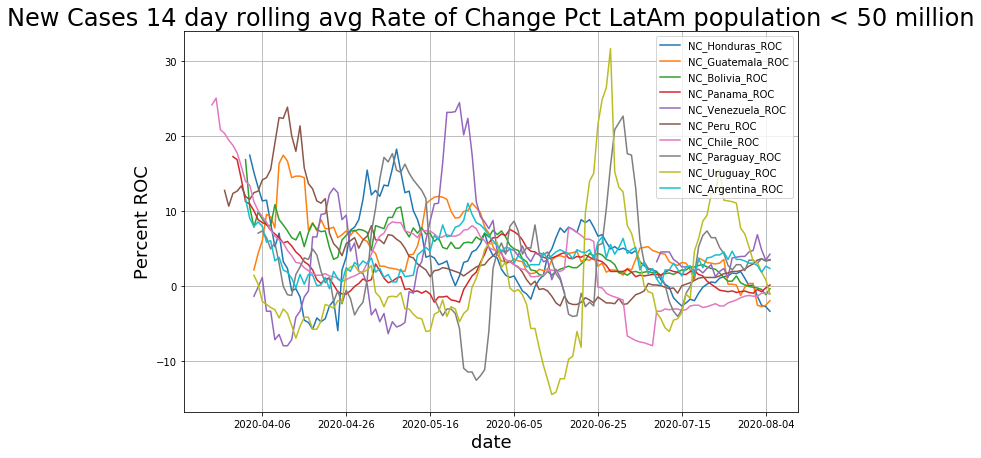

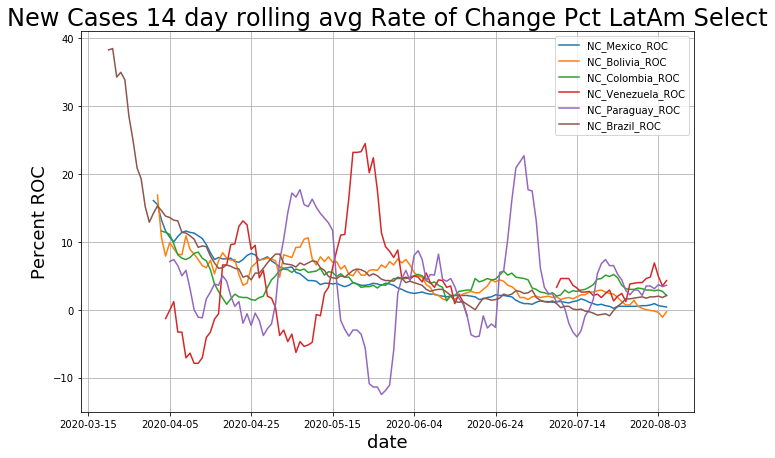

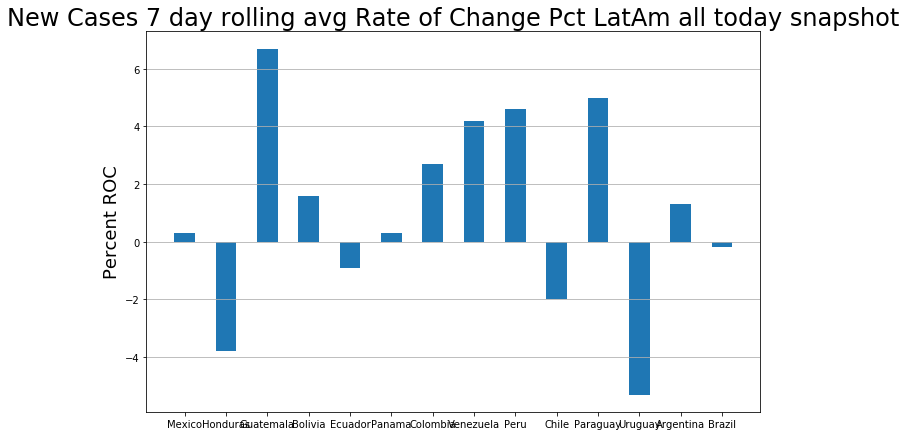

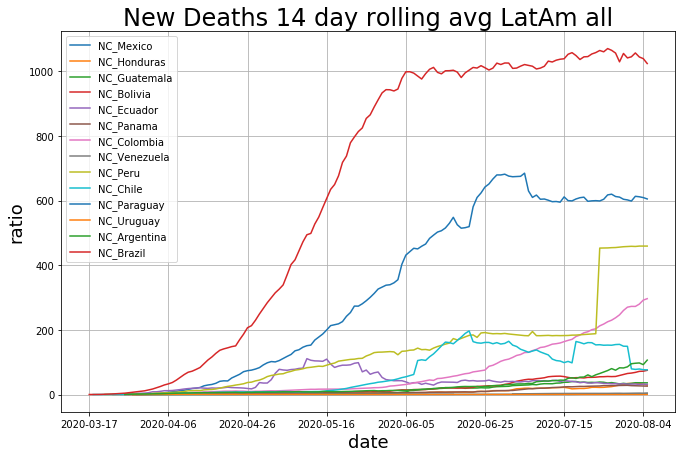

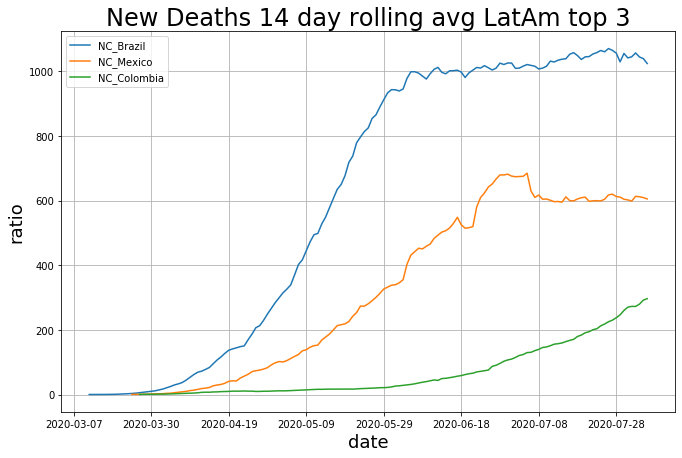

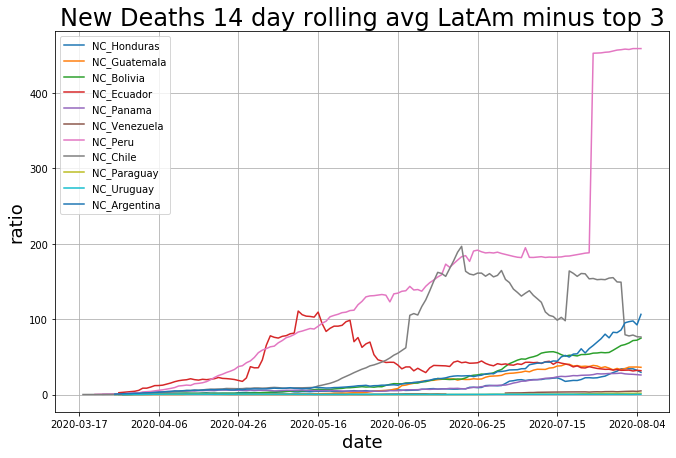

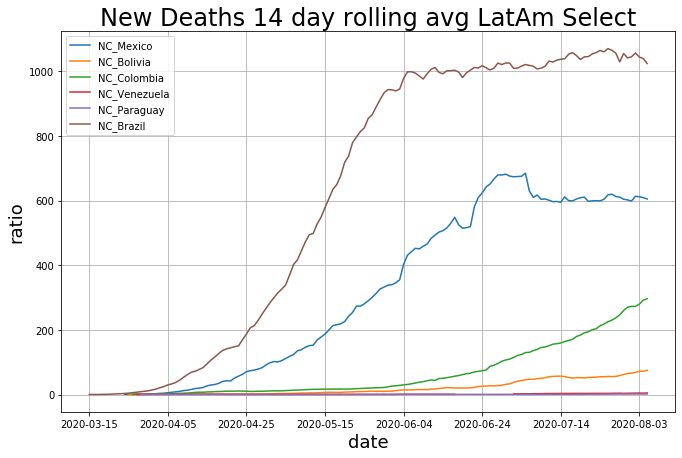

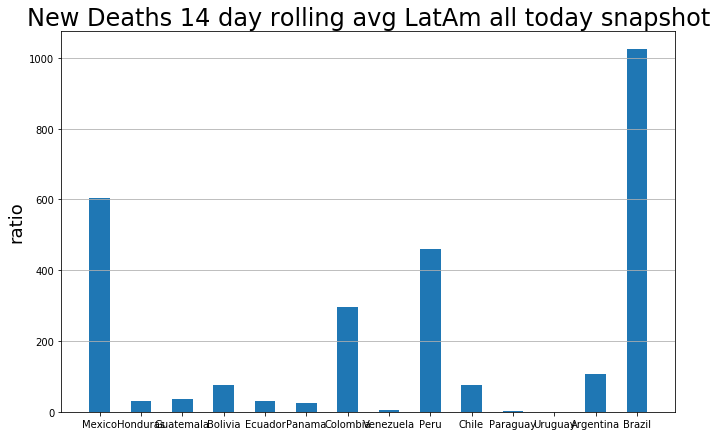

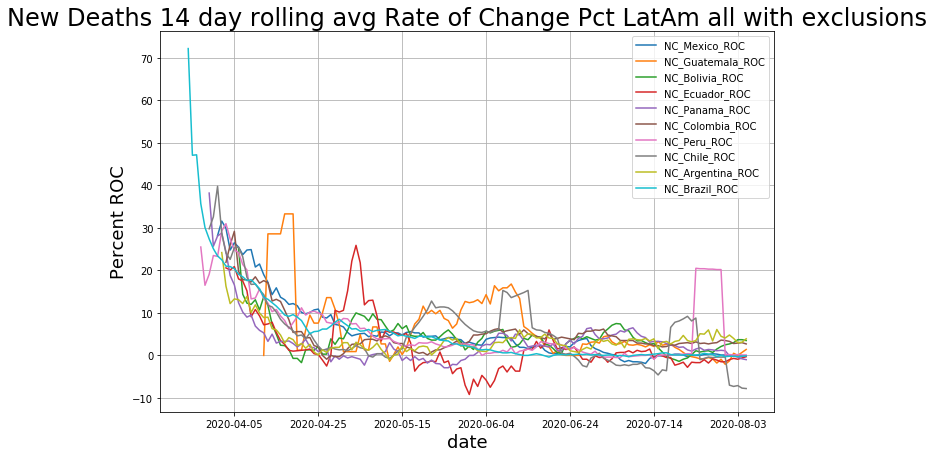

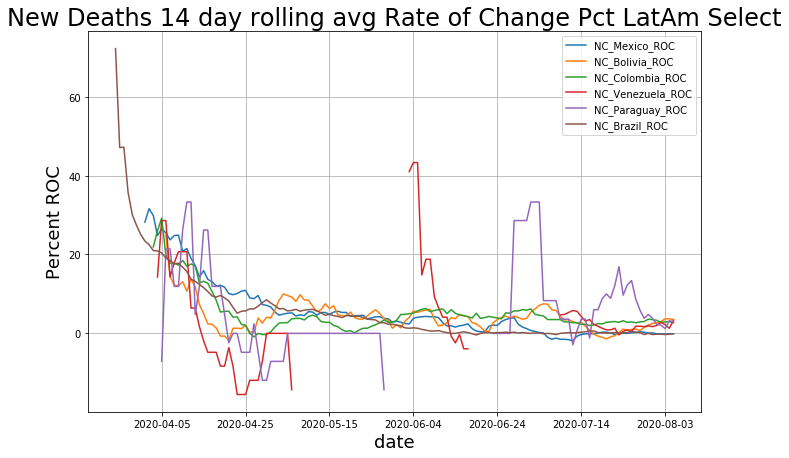

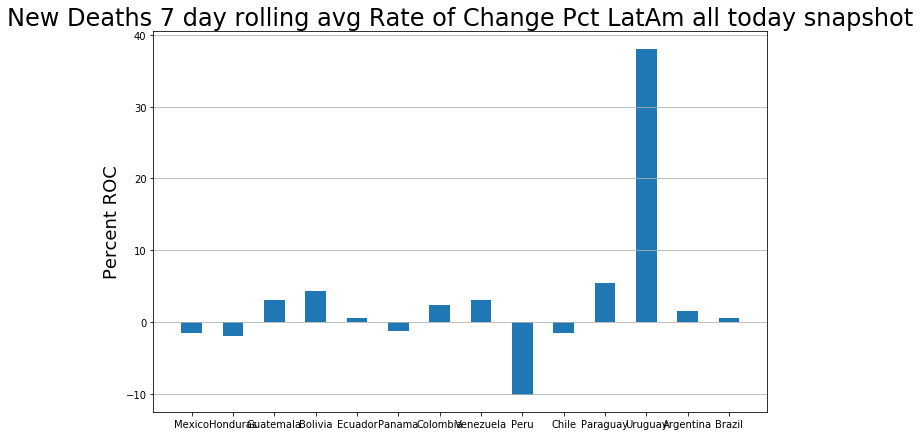

In [6]:

total_cases(latam_list, startdate, df, permil=False, titlextra='LatAm all')
total_cases(['Brazil','Chile','Peru','Mexico'], startdate, df, permil=False, titlextra='LatAm top 4')
total_cases(latam_list, startdate, df, permil=False, excludelist=['Brazil','Chile','Peru','Mexico'], titlextra='LatAm minus top 4')

total_cases(latam_list, startdate, df, permil=True, pop_dict=latampop_dict, excludelist=[], titlextra='LatAm all')
total_cases(['Chile','Panama','Peru','Brazil'], startdate, df, permil=True, pop_dict=latampop_dict, titlextra='LatAm top 4')
total_cases(latam_list, startdate, df, permil=True, pop_dict=latampop_dict, excludelist=['Chile','Panama','Peru','Brazil'], titlextra='LatAm minus top 4')

total_cases(latam_list, startdate, df, permil=True, pop_dict=latampop_dict, excludelist=[], kind='bar', titlextra='LatAm all')
total_cases(['Chile','Panama','Peru','Brazil'], startdate, df, permil=True, pop_dict=latampop_dict, kind='bar', titlextra='LatAm top 4')
total_cases(latam_list, startdate, df, permil=True, pop_dict=latampop_dict, excludelist=['Chile','Panama','Peru','Brazil'], kind='bar', titlextra='LatAm minus top 4')

total_cases(latam_list_select, startdate, df, permil=False, titlextra='LatAm Select')
total_cases(latam_list_select, startdate, df, permil=True, pop_dict=latampop_dict, titlextra='LatAm Select')
total_cases(latam_list_select, startdate, df, permil=True, pop_dict=latampop_dict, kind='bar', titlextra='LatAm Select')

ctd_ratio(latam_list, startdate, df, excludelist=[], titlextra='LatAm all')
ctd_ratio(['Paraguay','Venezuela','Chile','Panama'], startdate, df, excludelist=[], titlextra='LatAm top 4')
ctd_ratio(latam_list, startdate, df, excludelist=['Paraguay','Venezuela','Chile','Panama'], titlextra='LatAm minus top 4')
ctd_ratio(latam_list, startdate, df, excludelist=[], kind='bar', titlextra='LatAm all')

ctd_ratio(latam_list_select, startdate, df, excludelist=[], titlextra='LatAm Select')

new_cases(latam_list, startdate, df, titlextra='LatAm all')
new_cases(['Brazil','Mexico','Colombia'], startdate, df, titlextra='LatAm top 3')
new_cases(latam_list, startdate, df, excludelist=['Brazil','Mexico','Colombia'], titlextra='LatAm minus top 3')
new_cases(latam_list_select, startdate, df, titlextra='LatAm Select')
new_cases(latam_list, startdate, df, kind='bar', titlextra='LatAm all')

new_cases(latam_list_largepop, startdate, df, ROC=True, titlextra='LatAm population > 50 million', period=14)
new_cases(latam_list, startdate, df, ROC=True, excludelist=['Ecuador']+latam_list_largepop, period=14,
        titlextra='LatAm population < 50 million')
new_cases(latam_list_select, startdate, df, ROC=True, titlextra='LatAm Select', period=14)
new_cases(latam_list, startdate, df, kind='bar', ROC=True, titlextra='LatAm all')

new_cases(latam_list, startdate, df, casetype='deaths', period=14, titlextra='LatAm all')
new_cases(['Brazil','Mexico','Colombia'], startdate, df, casetype='deaths', period=14, titlextra='LatAm top 3')
new_cases(latam_list, startdate, df, casetype='deaths', period=14, titlextra='LatAm minus top 3',
         excludelist=['Brazil','Mexico','Colombia'])
new_cases(latam_list_select, startdate, df, casetype='deaths', period=14, titlextra='LatAm Select')
new_cases(latam_list, startdate, df, casetype='deaths', period=14, titlextra='LatAm all', kind='bar')

new_cases(latam_list, startdate, df, casetype='deaths', ROC=True, period=14,
          excludelist=['Honduras','Uruguay','Paraguay','Venezuela'], titlextra='LatAm all with exclusions')
new_cases(latam_list_select, startdate, df, casetype='deaths', ROC=True, period=14,
          titlextra='LatAm Select')
new_cases(latam_list, startdate, df, casetype='deaths', ROC=True, kind='bar', titlextra='LatAm all')


